In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import logging
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)


In [3]:
import random
def random_string(length,alphabet_list):
    rand_str = ''.join(random.choice(alphabet_list) for i in range(length))
    return rand_str

def perturb(seed,alphabet_list,p=0.5):
    seq=''
    for c in seed:
        if random.random() < p: c = random.choice(alphabet_list)
        seq += c
    return seq

def make_artificial_dataset(alphabet='ACGT', motives=None, motif_length=6, 
                            sequence_length=100, n_sequences=1000, n_motives=2, p=0.2,
                           random_state=1):
    random.seed(random_state)
    alphabet_list=[c for c in alphabet]
    
    if motives is None:
        motives=[]
        for i in range(n_motives):
            motives.append(random_string(motif_length,alphabet_list))
    else:
        motif_length = len(motives[0])
        n_motives = len(motives)
    
    sequence_length = sequence_length / len(motives)
    flanking_length = (sequence_length - motif_length ) / 2
    n_seq_per_motif = n_sequences

    counter=0
    seqs=[]
    for i in range(n_seq_per_motif):
        total_seq = ''
        total_binary_seq=''
        for j in range(n_motives):
            left_flanking = random_string(flanking_length,alphabet_list)
            right_flanking = random_string(flanking_length,alphabet_list)
            noisy_motif = perturb(motives[j],alphabet_list,p)
            seq = left_flanking + noisy_motif + right_flanking
            total_seq += seq
        seqs.append(('ID%d'%counter,total_seq))
        counter += 1
    binary_skeleton = '0' * flanking_length + '1' * motif_length + '0' * flanking_length
    binary_seq = binary_skeleton * n_motives
    return motives, seqs, binary_seq

In [4]:
from smod_wrapper import SMoDWrapper
from meme_wrapper import Meme
from dreme_wrapper import Dreme
from sklearn.cluster import KMeans
import time

In [5]:
def run_tool(motif_finder, scoring_criteria, pos_seqs, neg_seqs, 
             block_size, n_motives, min_motif_len, max_motif_len,
             complexity, min_score, min_freq, min_cluster_size,
             n_clusters, similarity_threshold, freq_threshold,p_value, 
             regex_th, sample_size, std_th):
    if motif_finder=='meme':
        with open('seqs.fa','w') as f_train:
            for seq in pos_seqs:
                f_train.write('>' + seq[0] + ' \n')
                f_train.write(seq[1] + '\n')

        tool =  Meme(alphabet='dna',
                     scoring_criteria = scoring_criteria,
                     minw=min_motif_len,
                     maxw=max_motif_len,
                     nmotifs=n_motives,
                     maxsize=1000000)
        start_time = time.time()
        tool.fit('seqs.fa')
    elif motif_finder=='dreme':
        with open('seqs.fa','w') as f_train:
            for seq in pos_seqs:
                f_train.write('>' + seq[0] + ' \n')
                f_train.write(seq[1] + '\n')
        tool = Dreme(alphabet='dna',
                     scoring_criteria=scoring_criteria,
                     mink=min_motif_len,
                     maxk=max_motif_len)
        start_time = time.time()
        tool.fit('seqs.fa')
    else:
        tool = SMoDWrapper(alphabet='dna',
                           scoring_criteria = scoring_criteria,
                           complexity = complexity,
                           n_clusters = n_clusters,
                           min_subarray_size = min_motif_len,
                           max_subarray_size = max_motif_len,
                           pos_block_size = block_size,
                           neg_block_size = block_size,
                           clusterer = KMeans(),
                           min_score = min_score,
                           min_freq = min_freq,
                           min_cluster_size = min_cluster_size,
                           similarity_th = similarity_threshold,
                           freq_th = freq_threshold,
                           p_value=p_value,
                           regex_th=regex_th,
                           sample_size=sample_size,
                           std_th=std_th)
        try:
            start_time = time.time()
            tool.fit(pos_seqs, neg_seqs)
        except:
            print "No motives found by SMoD."
            tool = None
    runtime = time.time() - start_time
    return runtime

In [6]:
import numpy as np
from sklearn.metrics import roc_auc_score
def evaluate(scoring_criteria='pwm', # ['pwm','hmm']
             motives=None,
             motif_length=6,
             n_motives=2,
             sequence_length=20,
             n_sequences=130,
             perturbation_prob=0.05,
             complexity=5,
             min_score=4,
             min_freq=0.25,
             min_cluster_size=5,
             n_clusters=15,
             min_subarray_size=5,
             max_subarray_size=10,
             similarity_threshold=.9,
             freq_threshold=None,
             p_value=0.05,
             regex_th=0.3,
             sample_size=200,
             std_th=None):

    motives, pos_seqs, binary_seq = make_artificial_dataset(alphabet='ACGT',
                                                            motives=motives,
                                                            sequence_length=sequence_length,
                                                            n_sequences=n_sequences,
                                                            motif_length=motif_length,
                                                            n_motives=n_motives,
                                                            p=perturbation_prob)
    
    from eden.modifier.seq import seq_to_seq, shuffle_modifier
    neg_seqs = seq_to_seq(pos_seqs, modifier=shuffle_modifier, times=1, order=2)
    neg_seqs = list(neg_seqs)

    block_size=n_sequences/8

    pos_size = len(pos_seqs)
    train_pos_seqs = pos_seqs[:pos_size/2]
    test_pos_seqs = pos_seqs[pos_size/2:]

    neg_size = len(neg_seqs)
    train_neg_seqs = neg_seqs[:neg_size/2]
    test_neg_seqs = neg_seqs[neg_size/2:]

    true_score = [float(int(i)) for i in binary_seq]

    tool_result = {'meme':[], 'smod':[], 'dreme':[]}
    for i in ['smod','meme', 'dreme']:
        runtime = run_tool(motif_finder=i,
                        scoring_criteria = scoring_criteria,
                        pos_seqs=train_pos_seqs, 
                        neg_seqs=train_neg_seqs,
                        block_size=block_size,
                        n_motives=n_motives, 
                        complexity = complexity,
                        min_motif_len=min_subarray_size,
                        max_motif_len=max_subarray_size,
                        min_score=min_score,
                        min_freq=min_freq,
                        min_cluster_size=min_cluster_size,
                        n_clusters=n_clusters,
                        similarity_threshold=similarity_threshold,
                        freq_threshold=freq_threshold,
                        p_value=p_value,
                        regex_th=regex_th,
                        sample_size=sample_size,
                        std_th=std_th)

        tool_result[i].append(runtime)
    return tool_result

In [9]:
% matplotlib inline
import pylab as plt 

def plot_results_3(data, title='Experiment', xlabel='param', ylabel='values', 
                   legend = ('MEME', 'SMoD', 'DREME')):
    data_x = np.array([param for param, val_m, val_s, val_d in data])
    data_y_m = np.array([val_m for param, val_m, val_s, val_d in data])
    data_d_m = np.array([val_m for param, val_m, val_s, val_d in data])
    data_y_s = np.array([val_s for param, val_m, val_s, val_d in data])
    data_d_s = np.array([val_s for param, val_m, val_s, val_d in data])
    data_y_d = np.array([val_s for param, val_m, val_s, val_d in data])
    data_d_d = np.array([val_s for param, val_m, val_s, val_d in data])
    
    plt.figure(figsize=(16,3))
    line_m, = plt.plot(data_x, data_y_m, lw=4, ls='-', color='cornflowerblue')
    plt.fill_between(data_x, data_y_m - data_d_m, data_y_m + data_d_m, alpha=0.1, color="b")
    plt.plot(data_x, data_y_m, marker='o', color='w',linestyle='None',
                markersize=10, markeredgecolor='cornflowerblue', markeredgewidth=3.0)
    
    line_s, = plt.plot(data_x, data_y_s, lw=4, ls='-', color='red')
    plt.fill_between(data_x, data_y_s - data_d_s, data_y_s + data_d_s, alpha=0.1, color="r")
    plt.plot(data_x, data_y_s, marker='o', color='w',linestyle='None',
                markersize=10, markeredgecolor='red', markeredgewidth=3.0)
    
    line_d, = plt.plot(data_x, data_y_d, lw=4, ls='-', color='green')
    plt.fill_between(data_x, data_y_d - data_d_d, data_y_d + data_d_d, alpha=0.1, color="g")
    plt.plot(data_x, data_y_d, marker='o', color='w',linestyle='None',
                markersize=10, markeredgecolor='green', markeredgewidth=3.0)
    
    d=10.0
    plt.xlim([min(data_x)-(max(data_x) - min(data_x))/d, max(data_x)+(max(data_x) - min(data_x))/d])
    #plt.ylim([0.5, 1])
    plt.suptitle(title, fontsize=16)
    plt.xlabel(xlabel, fontsize=12)
    plt.ylabel(ylabel, fontsize=12)
    plt.legend((line_m, line_s, line_d), legend, loc=0)
    plt.grid()
    plt.show()
    
def plot_results(data, title='Experiment', xlabel='param', ylabel='values', legend=('MEME', 'SMoD')):
    data_x = np.array([param for param, val_m, val_s in data])
    data_y_m = np.array([val_m for param, val_m, val_s in data])
    data_d_m = np.array([val_m for param, val_m, val_s in data])
    data_y_s = np.array([val_s for param, val_m, val_s in data])
    data_d_s = np.array([val_s for param, val_m, val_s in data])
    
    plt.figure(figsize=(16,3))
    line_m, = plt.plot(data_x, data_y_m, lw=4, ls='-', color='cornflowerblue')
    plt.fill_between(data_x, data_y_m - data_d_m, data_y_m + data_d_m, alpha=0.1, color="b")
    plt.plot(data_x, data_y_m, marker='o', color='w',linestyle='None',
                markersize=10, markeredgecolor='cornflowerblue', markeredgewidth=3.0)
    
    line_s, = plt.plot(data_x, data_y_s, lw=4, ls='-', color='red')
    plt.fill_between(data_x, data_y_s - data_d_s, data_y_s + data_d_s, alpha=0.1, color="r")
    plt.plot(data_x, data_y_s, marker='o', color='w',linestyle='None',
                markersize=10, markeredgecolor='red', markeredgewidth=3.0)
    
    d=10.0
    plt.xlim([min(data_x)-(max(data_x) - min(data_x))/d, max(data_x)+(max(data_x) - min(data_x))/d])
    #plt.ylim([0.5, 1])
    plt.suptitle(title, fontsize=16)
    plt.xlabel(xlabel, fontsize=12)
    plt.ylabel(ylabel, fontsize=12)
    plt.legend((line_m, line_s), legend, loc=0)
    plt.grid()
    plt.show()

/home/zr/anaconda2/envs/hiwi/lib/python2.7/site-packages/scipy/optimize/minpack.py:690: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


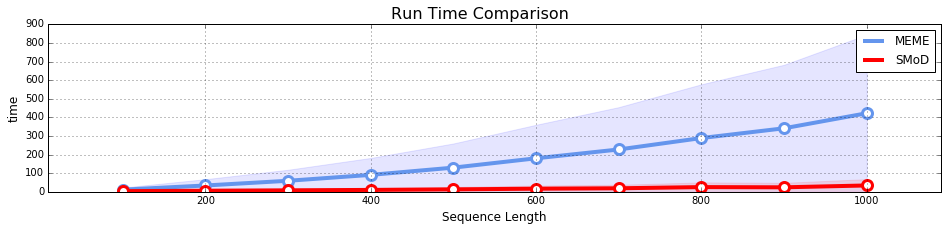

CPU times: user 41.5 s, sys: 3.43 s, total: 44.9 s
Wall time: 32min 27s


In [10]:
%%time

def make_results(n_rep=1):
    for param in [x*100 for x in range(1,11)]:
        results = {'meme':[], 'smod':[]}
        for rep in range(n_rep):
            tool_result = evaluate(scoring_criteria='pwm', # ['pwm','hmm']
                                   complexity=5,
                                   motif_length=10,
                                   n_motives=4,
                                   sequence_length=param,
                                   n_sequences=200,
                                   perturbation_prob=0.1,
                                   n_clusters=10,
                                   min_subarray_size=8,
                                   max_subarray_size=12,
                                   min_score=4,
                                   min_freq=0.45,
                                   min_cluster_size=2,
                                   similarity_threshold=0.80,
                                   freq_threshold=0.20,
                                   p_value=1,
                                   regex_th=0.5,
                                   sample_size=200,
                                   std_th = 1)            
            
            results['meme'].append(tool_result['meme'])
            results['smod'].append(tool_result['smod'])
        for tool in ['meme', 'smod']:
            avg = np.mean(results[tool])
            results[tool] = avg
        yield param, results['meme'], results['smod']


data = [(param, val_m, val_s) for param, val_m, val_s, in make_results()]
plot_results(data, title='Run Time Comparison', xlabel='Sequence Length', ylabel='time')

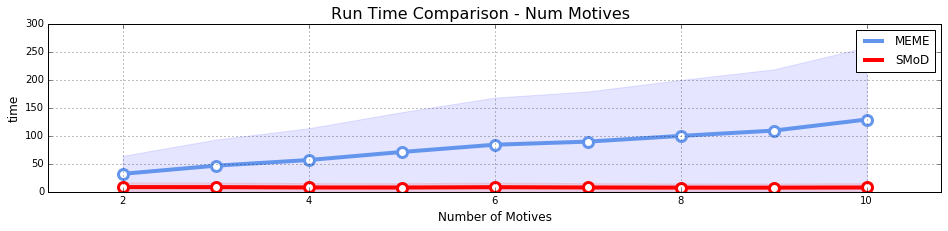

CPU times: user 36.4 s, sys: 4.61 s, total: 41 s
Wall time: 13min 13s


In [11]:
%%time

def make_results(n_rep=1):
    for param in [x for x in range(2,11)]:
        results = {'meme':[], 'smod':[]}
        for rep in range(n_rep):
            tool_result = evaluate(scoring_criteria='pwm', # ['pwm','hmm']
                                   complexity=5,
                                   motif_length=10,
                                   n_motives=param,
                                   sequence_length=300,
                                   n_sequences=200,
                                   perturbation_prob=0.1,
                                   n_clusters=10,
                                   min_subarray_size=8,
                                   max_subarray_size=12,
                                   min_score=4,
                                   min_freq=0.45,
                                   min_cluster_size=2,
                                   similarity_threshold=0.80,
                                   freq_threshold=0.20,
                                   p_value=1,
                                   regex_th=0.5,
                                   sample_size=200,
                                   std_th = 1)            
            
            results['meme'].append(tool_result['meme'])
            results['smod'].append(tool_result['smod'])
        for tool in ['meme', 'smod']:
            avg = np.mean(results[tool])
            results[tool] = avg
        yield param, results['meme'], results['smod']


data = [(param, val_m, val_s) for param, val_m, val_s, in make_results()]
plot_results(data, title='Run Time Comparison - Num Motives', xlabel='Number of Motives', ylabel='time')

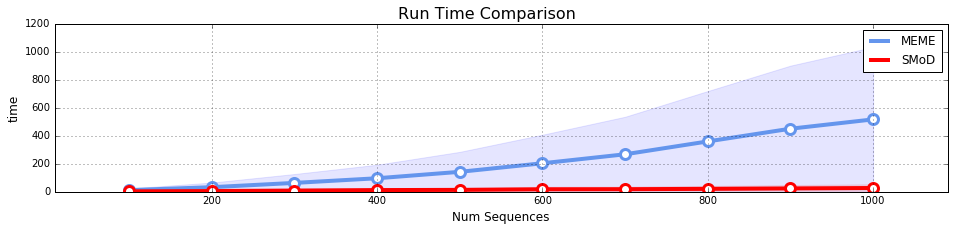

CPU times: user 59.7 s, sys: 7.03 s, total: 1min 6s
Wall time: 38min 29s


In [10]:
%%time

def make_results(n_rep=1):
    for param in [x*100 for x in range(1,11)]:
        results = {'meme':[], 'smod':[]}
        for rep in range(n_rep):
            tool_result = evaluate(scoring_criteria='pwm', # ['pwm','hmm']
                                   complexity=5,
                                   motif_length=10,
                                   n_motives=4,
                                   sequence_length=200,
                                   n_sequences=param,
                                   perturbation_prob=0.1,
                                   n_clusters=10,
                                   min_subarray_size=8,
                                   max_subarray_size=12,
                                   min_score=4,
                                   min_freq=0.45,
                                   min_cluster_size=2,
                                   similarity_threshold=0.80,
                                   freq_threshold=0.20,
                                   p_value=1,
                                   regex_th=0.5,
                                   sample_size=200,
                                   std_th = 1)            
            
            results['meme'].append(tool_result['meme'])
            results['smod'].append(tool_result['smod'])
        for tool in ['meme', 'smod']:
            avg = np.mean(results[tool])
            results[tool] = avg
        yield param, results['meme'], results['smod']


data = [(param, val_m, val_s) for param, val_m, val_s, in make_results()]
plot_results(data, title='Run Time Comparison', xlabel='Num Sequences', ylabel='time')

INFO:meme_wrapper:The output directory 'meme_out' already exists.
Its contents will be overwritten.
Initializing the motif probability tables for 2 to 50 sites...
nsites = 50
Done initializing.
SEEDS: highwater mark: seq 49 pos 200

seqs=    50, min= 200, max=  200, total=    10000

motif=1
SEED WIDTHS: 8 11 12
em: w=  12, psites=  50, iter=   0 
motif=2
SEED WIDTHS: 8 11 12
em: w=  12, psites=  50, iter=  10 
motif=3
SEED WIDTHS: 8 11 12
em: w=  12, psites=  50, iter=   0 
motif=4
SEED WIDTHS: 8 11 12
em: w=  12, psites=  50, iter=  10 

INFO:dreme_wrapper:
INFO:dreme_wrapper:DREME finished in 9 s
INFO:dreme_wrapper:Processing DREME output finished in 0 s
INFO:meme_wrapper:The output directory 'meme_out' already exists.
Its contents will be overwritten.
Initializing the motif probability tables for 2 to 100 sites...
nsites = 100
Done initializing.
SEEDS: highwater mark: seq 99 pos 200

seqs=   100, min= 200, max=  200, total=    20000

motif=1
SEED WIDTHS: 8 11 12
em: w=  12, psites= 

No motives found by SMoD.


INFO:meme_wrapper:The output directory 'meme_out' already exists.
Its contents will be overwritten.
Initializing the motif probability tables for 2 to 150 sites...
nsites = 150
Done initializing.
SEEDS: highwater mark: seq 149 pos 200

seqs=   150, min= 200, max=  200, total=    30000

motif=1
SEED WIDTHS: 8 11 12
em: w=  12, psites= 150, iter=   0 
motif=2
SEED WIDTHS: 8 11 12
em: w=  12, psites= 150, iter=   0 
motif=3
SEED WIDTHS: 8 11 12
em: w=  12, psites= 150, iter=  10 
motif=4
SEED WIDTHS: 8 11 12
em: w=  12, psites= 150, iter=   0 

INFO:dreme_wrapper:
INFO:dreme_wrapper:DREME finished in 29 s
INFO:dreme_wrapper:Processing DREME output finished in 0 s
INFO:meme_wrapper:The output directory 'meme_out' already exists.
Its contents will be overwritten.
Initializing the motif probability tables for 2 to 200 sites...
nsites = 200
Done initializing.
SEEDS: highwater mark: seq 199 pos 200

seqs=   200, min= 200, max=  200, total=    40000

motif=1
SEED WIDTHS: 8 11 12
em: w=  12, psi

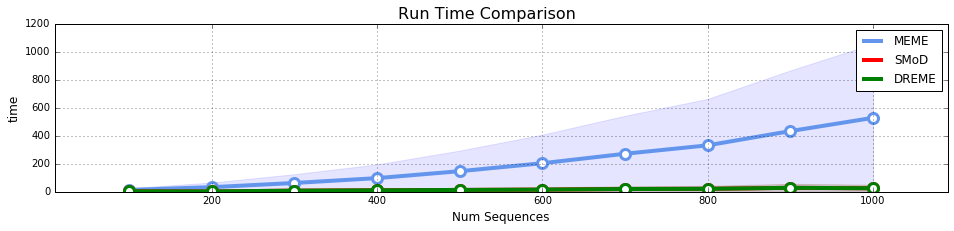

CPU times: user 1min 11s, sys: 4.42 s, total: 1min 15s
Wall time: 51min 1s


In [6]:
%%time

def make_results(n_rep=1):
    for param in [x*100 for x in range(1,11)]:
        results = {'meme':[], 'smod':[], 'dreme':[]}
        for rep in range(n_rep):
            tool_result = evaluate(scoring_criteria='pwm', # ['pwm','hmm']
                                   complexity=5,
                                   motif_length=10,
                                   n_motives=4,
                                   sequence_length=200,
                                   n_sequences=param,
                                   perturbation_prob=0.1,
                                   n_clusters=10,
                                   min_subarray_size=8,
                                   max_subarray_size=12,
                                   min_score=4,
                                   min_freq=0.45,
                                   min_cluster_size=2,
                                   similarity_threshold=0.80,
                                   freq_threshold=0.20,
                                   p_value=1,
                                   regex_th=0.5,
                                   sample_size=200,
                                   std_th = 1)            
            
            results['meme'].append(tool_result['meme'])
            results['smod'].append(tool_result['smod'])
            results['dreme'].append(tool_result['dreme'])
        for tool in ['meme', 'smod', 'dreme']:
            avg = np.mean(results[tool])
            results[tool] = avg
        yield param, results['meme'], results['smod'], results['dreme']


data = [(param, val_m, val_s, val_d) for param, val_m, val_s, val_d in make_results()]
plot_results_3(data, title='Run Time Comparison', 
               xlabel='Num Sequences', ylabel='time',
               legend=('MEME', 'SMoD', 'DREME'))

In [8]:
%%time

def make_results(n_rep=1):
    for param in [x*100 for x in range(1,11)]:
        results = {'smod':[], 'dreme':[]}
        for rep in range(n_rep):
            tool_result = evaluate(scoring_criteria='pwm', # ['pwm','hmm']
                                   complexity=5,
                                   motif_length=10,
                                   n_motives=4,
                                   sequence_length=200,
                                   n_sequences=param,
                                   perturbation_prob=0.1,
                                   n_clusters=10,
                                   min_subarray_size=8,
                                   max_subarray_size=12,
                                   min_score=4,
                                   min_freq=0.45,
                                   min_cluster_size=2,
                                   similarity_threshold=0.80,
                                   freq_threshold=0.20,
                                   p_value=1,
                                   regex_th=0.5,
                                   sample_size=200,
                                   std_th = 1)            
            
            results['smod'].append(tool_result['smod'])
            results['dreme'].append(tool_result['dreme'])
        for tool in ['smod', 'dreme']:
            avg = np.mean(results[tool])
            results[tool] = avg
        yield param, results['smod'], results['dreme']


data = [(param, val_s, val_d) for param, val_s, val_d in make_results()]
plot_results(data, title='Run Time Comparison', 
               xlabel='Num Sequences', ylabel='time',
               legend=('SMoD', 'DREME'))

/home/zr/eden/EDeN/eden/sequence_motif_decomposer.py:48: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-(x - a) / b))


ValueError: need more than 3 values to unpack

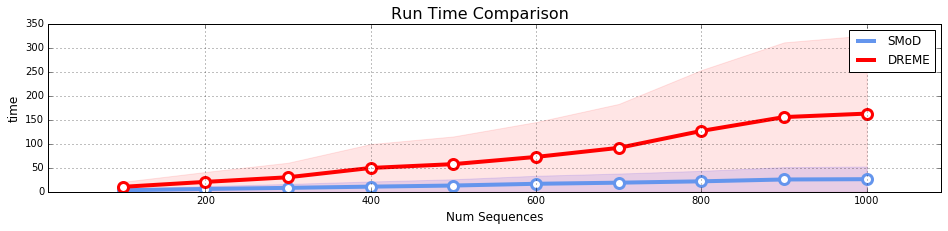

In [10]:
plot_results(data, title='Run Time Comparison', 
               xlabel='Num Sequences', ylabel='time',
               legend=('SMoD', 'DREME'))